# Import necessary modules

In [3]:
# import sys
# sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.api import tsa 
from statsmodels.tsa.stattools import adfuller, kpss
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


# Preprocessing Data

## Read data

In [4]:
# Read csv file into a dataframe
file_path = "../data/D_raw_three_year_data.csv"
df = pd.read_csv(file_path)
df

,date,organic,organic_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,conversion
0,2021-01-03,272,270.316305,1418.616426,5931.415947,5707.238400,351
1,2021-01-04,209,211.611690,2390.720840,2837.504860,4421.170800,296
2,2021-01-05,289,231.650902,4653.089039,4066.729978,4631.660020,420
3,2021-01-06,377,412.610037,2234.013683,4601.921825,8008.348062,513
4,2021-01-07,203,210.239703,2147.635245,2784.604762,3323.354878,307
...,...,...,...,...,...,...,...
1145,2022-09-25,209,231.801584,1916.004354,3049.995745,6187.086323,326
1146,2022-01-05,362,355.006176,3629.522188,6164.483188,4888.822000,510
1147,2021-11-22,534,615.910176,4933.883625,4769.213645,12537.745792,716
1148,2023-07-03,491,491.919604,6181.044737,9806.637531,11184.966479,736


## Check dimensions

In [5]:
# dataframe dimensions
print(f"This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.")

This dataframe has 1150 rows and 7 columns.


## Check data types

In [6]:
# columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 1150 non-null   object 
 1   organic              1150 non-null   int64  
 2   organic_proxy        1150 non-null   float64
 3   tv_ad_spend_raw      1130 non-null   float64
 4   social_ad_spend_raw  1129 non-null   float64
 5   search_ad_spend_raw  1133 non-null   float64
 6   conversion           1150 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 63.0+ KB


## Remove duplicates

In [7]:
# Check for duplicate rows
duplicate_count = df.duplicated(subset=['date']).sum()



# Display the result
if duplicate_count > 0:
    print(f"There are {duplicate_count} duplicate based on the 'date' column.")
else:
    print("No duplicate based on the 'date' column found in the DataFrame.")

There are 55 duplicate based on the 'date' column.


In [8]:
# Remove duplicates
df = df.drop_duplicates(subset=['date'], keep='first').reset_index(drop=True)
print(f"The dataframe now has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe now has 1095 rows and 7 columns.


## Preprocess Missing Values

In [9]:
# missing values summary
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum()\
                     / df.shape[0]\
                     * 100),
            columns=['Column', 'Has Missing Values', '% Missing Values'])

,Column,Has Missing Values,% Missing Values
0,date,False,0.000000
1,organic,False,0.000000
2,organic_proxy,False,0.000000
3,tv_ad_spend_raw,True,1.826484
4,social_ad_spend_raw,True,1.735160
5,search_ad_spend_raw,True,1.461187
6,conversion,False,0.000000


In [10]:
# Replace missing values with the average of the preceding and following row
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:  # Apply only to numeric columns
        for index in df[col][df[col].isna()].index:  # Get indices of NaN values
            prev_value = df[col].iloc[index - 1] if index > 0 else np.nan
            next_value = df[col].iloc[index + 1] if index < len(df) - 1 else np.nan
            
            # Compute average only if both values exist
            if not np.isnan(prev_value) and not np.isnan(next_value):
                df.at[index, col] = (prev_value + next_value) / 2
            elif not np.isnan(prev_value):  # If only previous exists
                df.at[index, col] = prev_value
            elif not np.isnan(next_value):  # If only next exists
                df.at[index, col] = next_value

print(f"The dataframe now has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe now has 1095 rows and 7 columns.


In [11]:
# Check missing values again
pd.DataFrame(zip(df.columns,
                 df.isna().any(),
                 df.isna().sum()\
                     / df.shape[0]\
                     * 100),
            columns=['Column', 'Has Missing Values', '% Missing Values'])

,Column,Has Missing Values,% Missing Values
0,date,False,0.0
1,organic,False,0.0
2,organic_proxy,False,0.0
3,tv_ad_spend_raw,False,0.0
4,social_ad_spend_raw,False,0.0
5,search_ad_spend_raw,False,0.0
6,conversion,False,0.0


## Sort by date column and reset index

In [12]:
df['date'] = pd.to_datetime(df['date'])  # Convert to datetime format if not already
df = df.sort_values(by='date').reset_index(drop=True)  # Sort and reset index
print(f"The dataframe now has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataframe now has 1095 rows and 7 columns.


In [13]:
df

,date,organic,organic_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,conversion
0,2021-01-03,272,270.316305,1418.616426,5931.415947,5707.238400,351
1,2021-01-04,209,211.611690,2390.720840,2837.504860,4421.170800,296
2,2021-01-05,289,231.650902,4653.089039,4066.729978,4631.660020,420
3,2021-01-06,377,412.610037,2234.013683,4601.921825,8008.348062,513
4,2021-01-07,203,210.239703,2147.635245,2784.604762,3323.354878,307
...,...,...,...,...,...,...,...
1090,2023-12-29,483,557.511952,3584.266702,8656.036271,14063.037094,708
1091,2023-12-30,487,418.348640,4922.057126,2111.017311,10873.500493,672
1092,2023-12-31,565,550.209233,2002.711193,13673.798619,10039.300416,772
1093,2024-01-01,498,477.295533,6298.291055,8143.185789,8477.342769,721


# Exploratory Data Analysis

In [14]:
df_eda = df.copy()

## Basic summary statistics (or) Univariate analysis

In [15]:
# Summary
df_eda.iloc[:,1:].describe()

,organic,organic_proxy,tv_ad_spend_raw,social_ad_spend_raw,search_ad_spend_raw,conversion
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,391.094064,392.945538,3891.458101,5783.552019,7805.194973,564.088584
std,124.947840,131.367329,1694.782522,2608.318900,3516.046822,165.230039
min,-26.000000,24.842204,259.347107,242.421481,357.166894,22.000000
25%,305.500000,302.834439,2632.876430,3827.155241,5274.605723,451.000000
50%,388.000000,391.008846,3706.660902,5583.137546,7496.726890,561.000000
75%,478.500000,479.596734,4985.263936,7378.052970,9785.299416,681.500000
max,745.000000,855.221340,10378.996461,20016.908490,21739.600082,1043.000000


This tabular is quite informative. On average, the brand seems to be speding extremely high for search ad, and least on tv ad.

<Axes: >

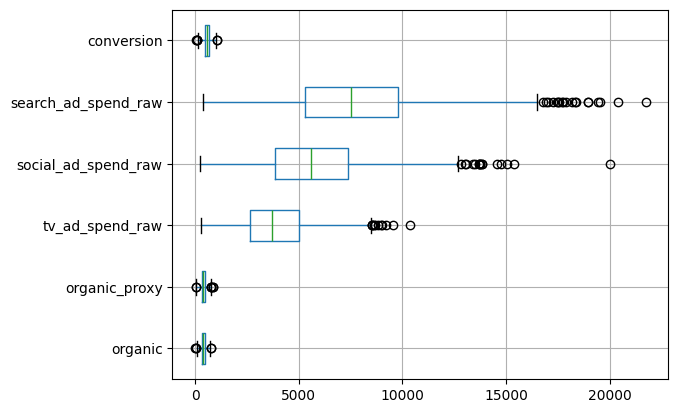

In [16]:
df_eda.iloc[:,1:].boxplot(vert=0)

On a closer examination of the data, we can identify that there are few outliers in the data.

## Handeling outlier

In [17]:
# Using Interquartile range (IQR)
def detect_outlier(col):
    sorted(col)
    lower_quartile, upper_quartile = np.percentile(col, [25, 75])
    IQR = upper_quartile - lower_quartile
    lower_bound = lower_quartile - (1.5 * IQR)
    upper_bound = upper_quartile + (1.5 * IQR)

    return lower_bound, upper_bound

In [18]:
for col in df_eda.select_dtypes(include=['number']).columns: # [float or int64]
    lower_range, upper_range = detect_outlier(df_eda[col])
    df_eda[col] = np.where(df_eda[col] > upper_range, upper_range, df_eda[col])
    df_eda[col] = np.where(df_eda[col] < lower_range, lower_range, df_eda[col])

In [19]:
df_eda.boxplot(vert=0)

<Axes: >

## Bivariate and Multivariate analysis

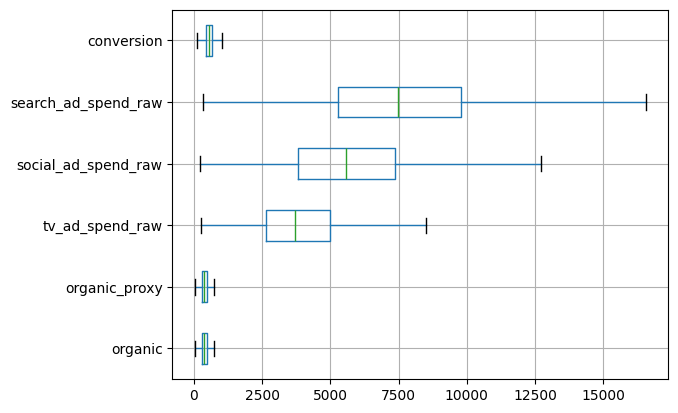

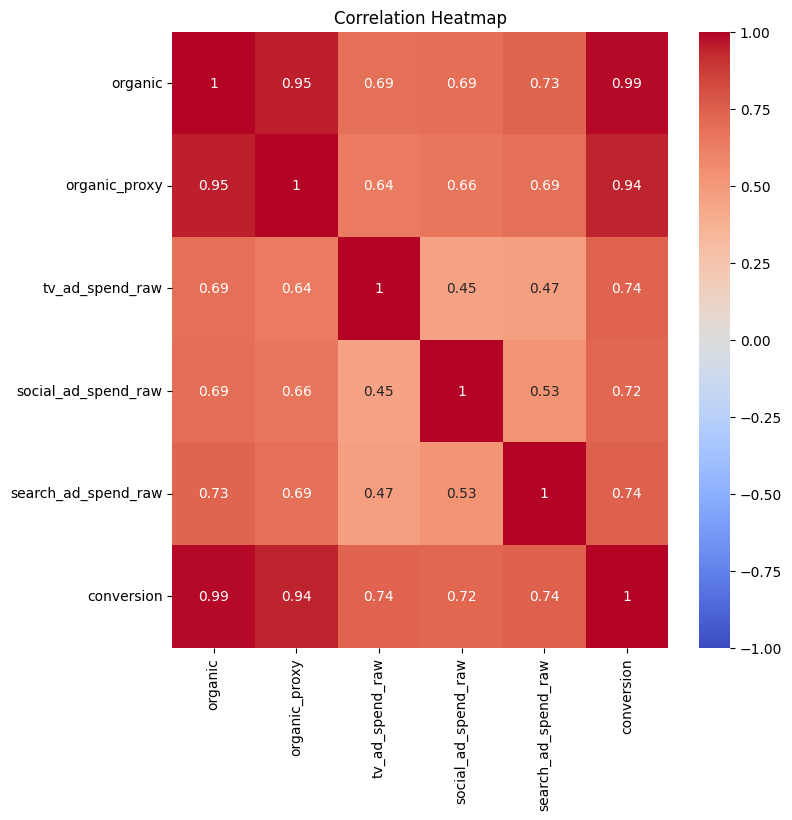

In [20]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.iloc[:,1:].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

**Comment:** Our variables are highly correlated.

## Demand and Proxy Demand

<Figure size 800x500 with 0 Axes>

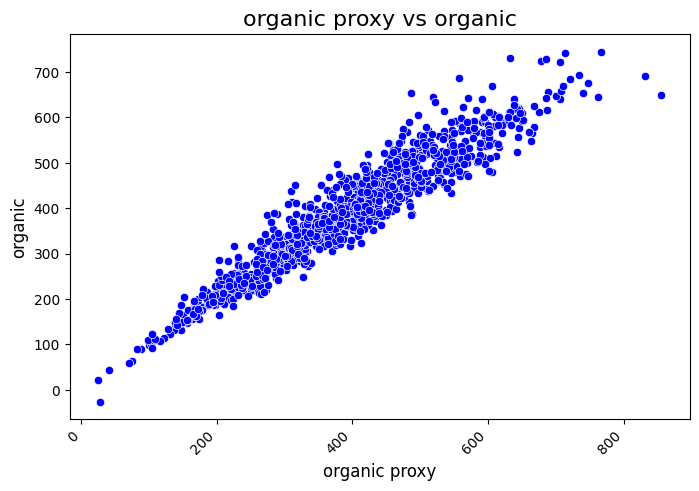

In [22]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=df['organic_proxy'], y=df['organic'], color="blue")

plt.title('organic proxy vs organic', fontsize=16)
plt.xlabel('organic proxy', fontsize=12)
plt.ylabel('organic', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

**Comments:**
* Our generated demand was based on an increasing trend for organic growth, along with demand fluctuations observed over each period of the year.
* However, in reality, demand is an unobserved variable. Instead, we can use proxies for demand as control variables in the model. In digital marketing, for example, Google Search Trends data for the product being sold can serve as a useful demand proxy.

## Marketing Channel Spend

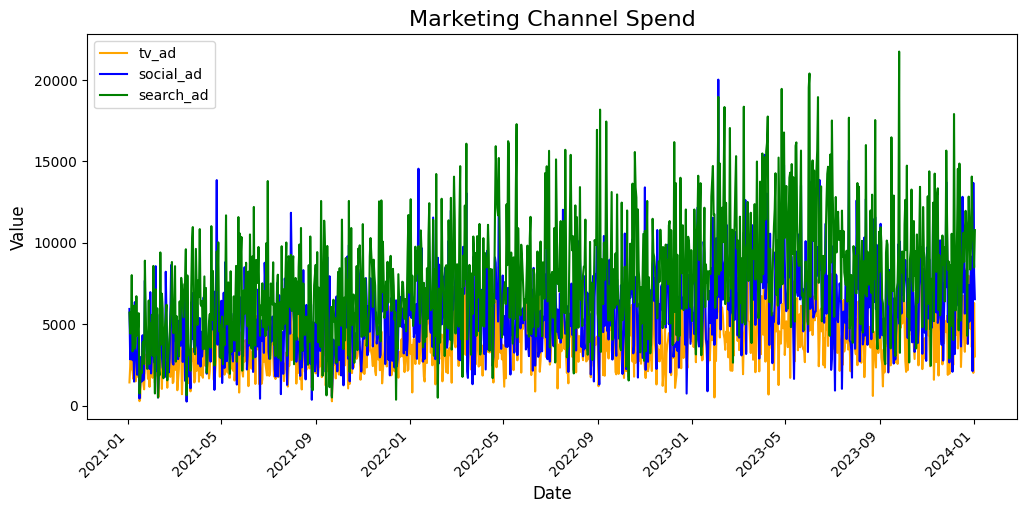

In [23]:
channels = ["tv_ad", "social_ad", "search_ad"]
plt.figure(figsize=(12, 5))

sns.lineplot(x=df['date'], y=df['tv_ad_spend_raw'], label=channels[0], color="orange")
sns.lineplot(x=df['date'], y=df['social_ad_spend_raw'], label=channels[1], color="blue")
sns.lineplot(x=df['date'], y=df['search_ad_spend_raw'], label=channels[2], color="green")
plt.title('Marketing Channel Spend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

## Sales (Conversion)

<Figure size 1200x500 with 0 Axes>

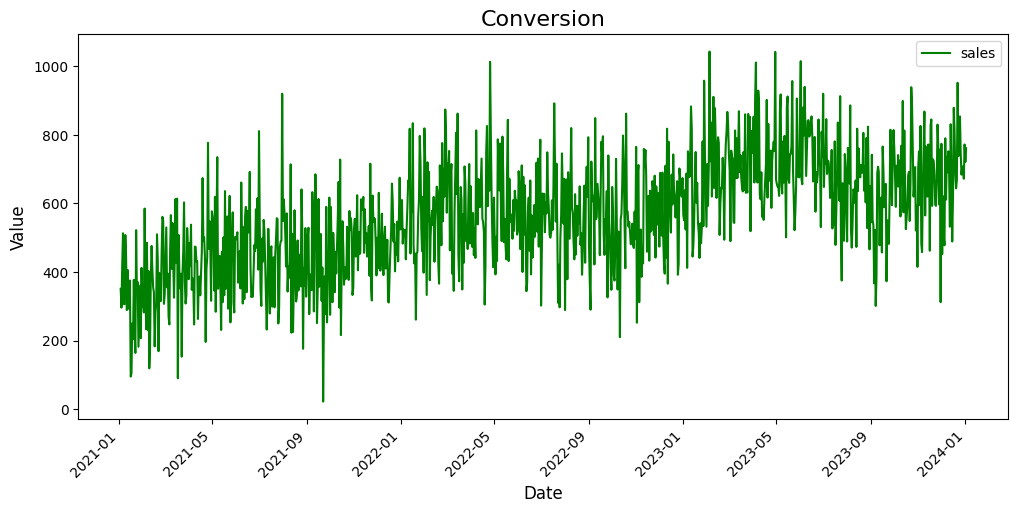

In [25]:
plt.figure(figsize=(12, 5))

sns.lineplot(x=df['date'], y=df['conversion'], label="sales", color="green")

plt.title('Conversion', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

## Decomposing Time Series

We will be decomposing the time series using additive decomposition so that we can observe the underlying trend, seasonality and residuals.

Additive Decomposition : Trend + Seasonality + Residual

In [26]:
# decompose the time series
df_composition = df_eda.copy()
df_composition = df_composition[["date", "conversion"]]
df_composition['date'] = pd.to_datetime(df_eda['date'], format="%Y-%m-%d")
df_composition = df_composition.set_index('date')

decomposition = tsa.seasonal_decompose(df_composition, model='additive')
#saving copy to new datafrme
df_daily=df_composition.copy()
# add the decomposition data
df_daily['Trend'] = decomposition.trend
df_daily['Seasonal'] = decomposition.seasonal
df_daily['Residual'] = decomposition.resid

In [27]:
df_daily

,conversion,Trend,Seasonal,Residual
date,,,,
2021-01-03,351.0,NaN,7.576490,NaN
2021-01-04,296.0,NaN,7.088472,NaN
2021-01-05,420.0,NaN,-16.514293,NaN
2021-01-06,513.0,385.857143,7.322223,119.820634
2021-01-07,307.0,399.428571,-12.569718,-79.858853
...,...,...,...,...
2023-12-29,708.0,715.571429,-0.883592,-6.687837
2023-12-30,672.0,717.857143,7.980419,-53.837562
2023-12-31,772.0,NaN,7.576490,NaN


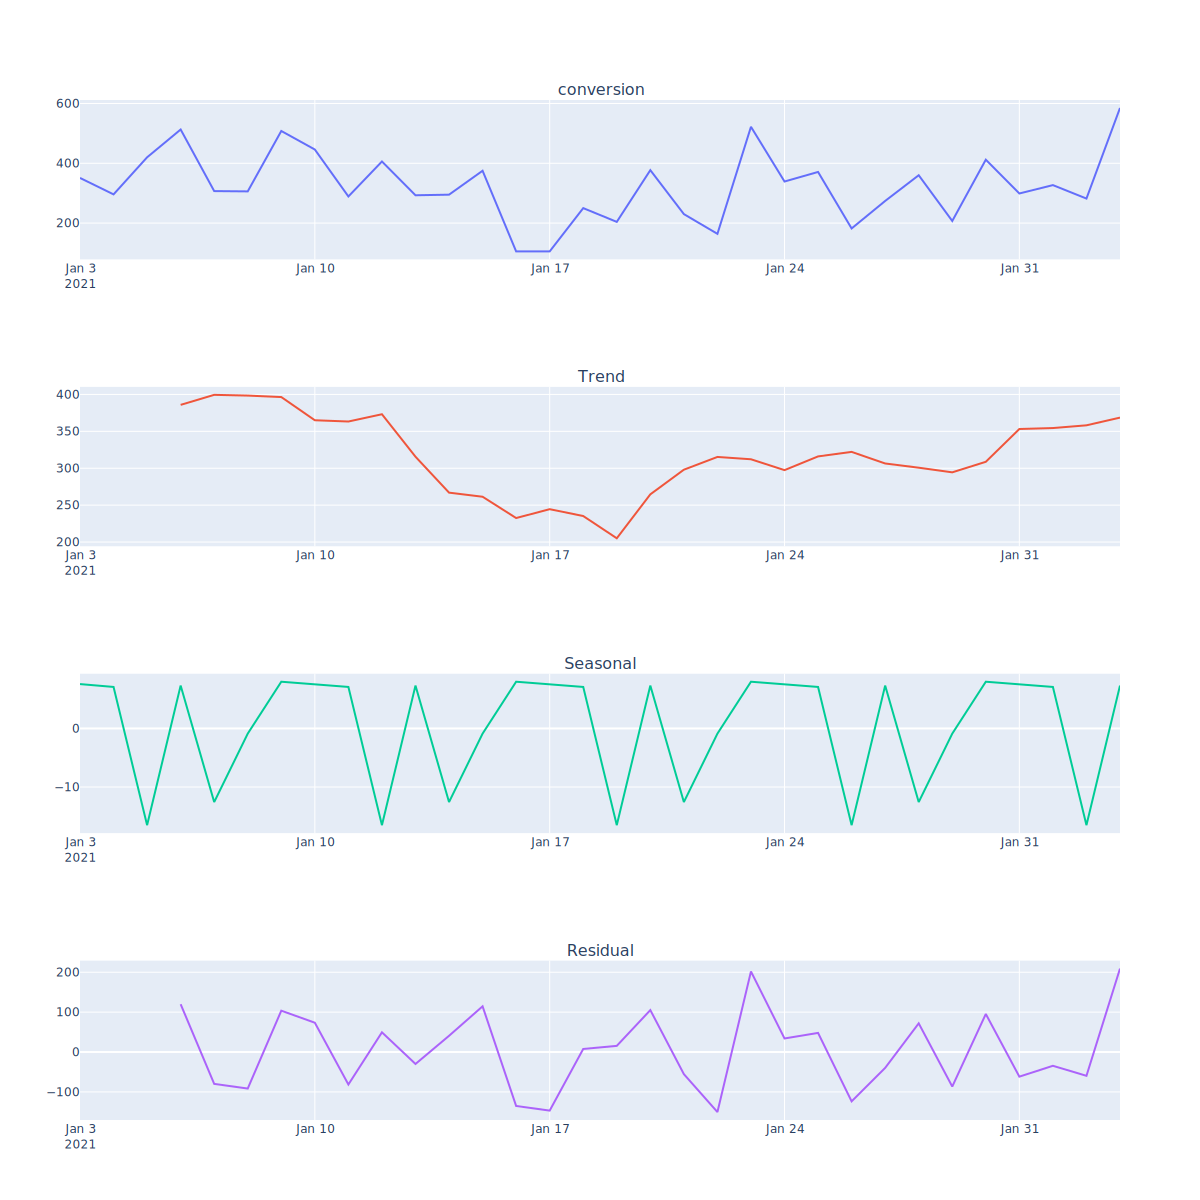

In [29]:

#plotting the actual and decomposed componenets of time series
# Check in 1 months to see more about seasonality
cutoff_date = df_daily.index.min() + pd.DateOffset(months=1)
df_check = df_daily[df_daily.index <= cutoff_date]

cols = ["conversion", "Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=4, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=df_check.index, y=df_check[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=1200, width=1200, showlegend=False)
# fig.show()
fig.show("svg")

**Observations:**
* The trend shows a significant increase over the three-year period from 2021 to 2023.*
* There is a half-year seasonality: demand is high during the first six months and lower in the second half of the year.
* There is no clear pattern in residual.

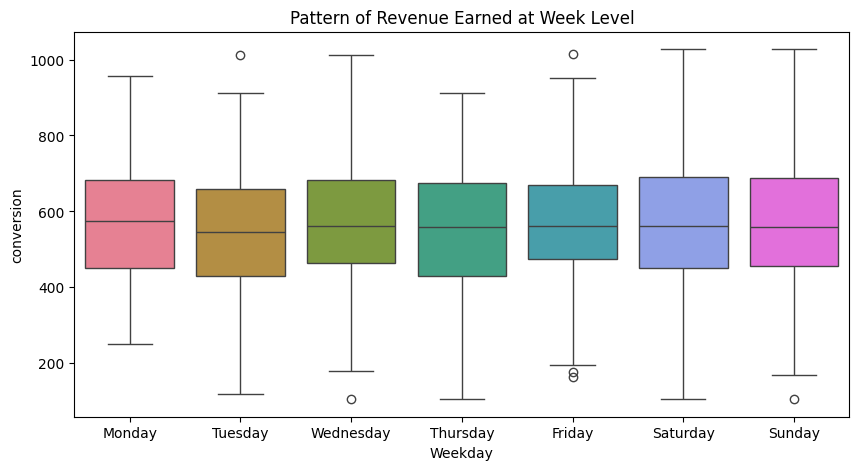

In [32]:
# Copying the daily DataFrame
df_week_check = df_daily.copy()

# Extracting weekday as integer (0=Monday, 6=Sunday)
df_week_check['Weekday'] = df_week_check.index.weekday

# Define ordered categories for weekdays
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Mapping numeric weekdays to named weekdays
df_week_check['Weekday'] = df_week_check['Weekday'].apply(lambda x: week_order[x])

# Set the categorical type to ensure the order in the plot
df_week_check['Weekday'] = pd.Categorical(df_week_check['Weekday'], categories=week_order, ordered=True)

# Create figure
plt.figure(figsize=(10, 5))
plt.title('Pattern of Revenue Earned at Week Level')

# Set color palette with 7 distinct colors
palette = sns.color_palette("husl", 7)

# Boxplot with ordered weekdays and color mapping
sns.boxplot(data=df_week_check, x='Weekday', y='conversion', palette=palette);

# Show the plot
plt.show()


**Observations:**
* We can see that the amount earned is high on monday and tuesday. It decrease towards the end of week.
* There are some outliers on Friday and Saturday because of the holidays.

We can now proceed ahead with the checking stationarity of the time series so that we can apply modelling.

# Checking stationarity

Forecasting is bulit on assumption that historical data is representative of the future. It is important for a time series to be stationary, if it is not it means that that data changes over time and it will be hard to forecast that data.

If the mean and variance of the time series are constant that means the time series is sationary. We will plot the rolling mean and rolling standard deviation for the time series to visually chacke for stationarity.

* A rolling average can help you find trends that would otherwise be hard to detect.
* Volatility is based on standard deviation, a measure of how much the data varies from the average - or the measure of spread.

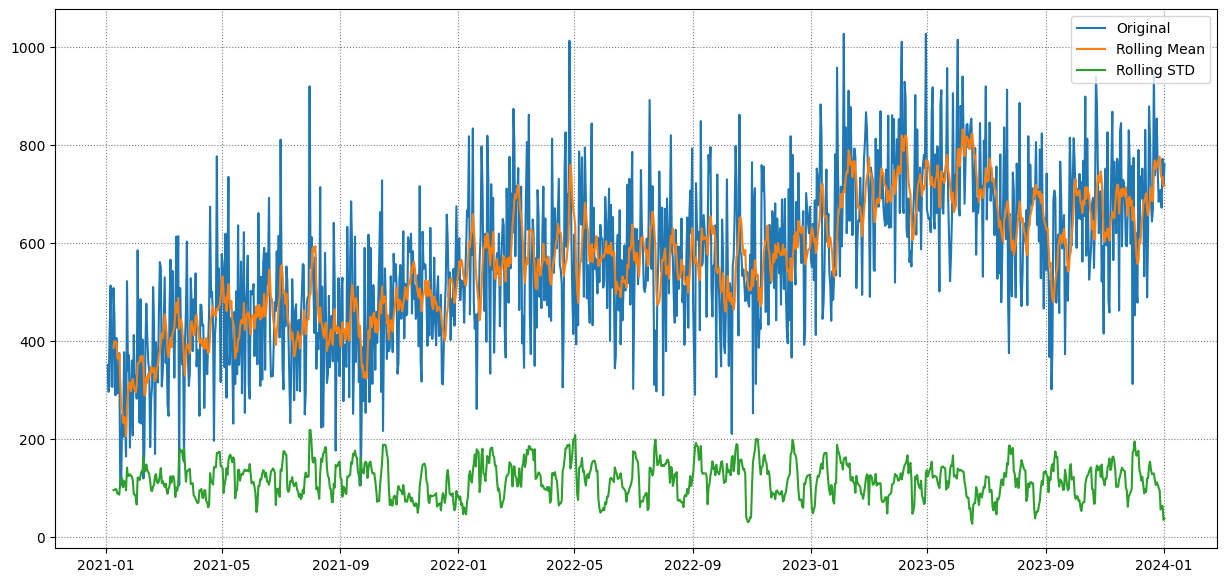

In [33]:
#plotting rolling mean and standard deviation.

# Get Things Rolling
roll_mean = df_daily['conversion'].rolling(window=7).mean()
roll_std = df_daily['conversion'].rolling(window=7).std()
    
# Figure
fig, ax = plt.subplots(figsize=(15,7), facecolor='w')
ax.plot(df_daily['conversion'], label='Original')
ax.plot(roll_mean, label='Rolling Mean')
ax.plot(roll_std,  label='Rolling STD')
    
# Legend & Grid
ax.legend(loc='upper right')
plt.grid(linestyle=":", color='grey')
plt.show()

### Statistical tests to check stationarity

### ADF - Augmented Dickey Fuller Test

ADF test is used to determine the presence of unit root in the series, the presence of a unit root means the time series is non-stationary. Besides, the number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary. The null and alternate hypothesis of this test are:

$H_0$ : The series has a unit root. 

$H_a$: The series has no unit root.

If the null hypothesis is failed to be rejected (the p-value obtained is greater than the significance level (say 0.05)), this test may provide evidence that the series is non-stationary.


### KPSS - Kwiatkowski-Phillips-Schmidt-Shin

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_0$ : The process is trend stationary.

$H_a$: The series has a unit root (series is not stationary).

In [ ]:
def perform_adf_test(df) -> None:
    """
    Augmented Dickey Fuller Test
    - The null hypothesis for this test is that there is a unit root.
    - The alternate hypothesis is that there is no unit root in the series.
    ---
    Args:
        df (pd.DataFrame): Dataframe contains the timeseries data
        
    Returns: None
    """
    
    adf_stat, p_value, n_lags, n_observ, crit_vals, icbest = adfuller(df)
    
    print('\nAugmented Dickey Fuller Test')
    print('---'*15)
    print('ADF Statistic: %f' % adf_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Number of observations used: {n_observ}')
    print(f'T values corresponding to adfuller test:')
    for key, value in crit_vals.items():
        print(key, value)


def perform_kpss_test(df) -> None:
    """
    Kwiatkowski-Phillips-Schmidt-Shin test for stationary.
    - The null hypothesis for the test is that the data is stationary.
    - The alternate hypothesis for the test is that the data is not stationary.
    ---
    Args:
        df (pd.DataFrame): Dataframe that contains the timeseries data
        
    Returns: None
    """
    
    kpss_stat, p_value, n_lags, crit_vals = kpss(df, nlags='auto', store=False)
    print('\nKwiatkowski-Phillips-Schmidt-Shin test')
    print('---'*15)
    print('KPSS Statistic: %f' % kpss_stat)
    print('p-value: %f' % p_value)
    print(f'Number of lags used: {n_lags}')
    print(f'Critical values of KPSS test:')
    for key, value in crit_vals.items():
        print(key, value)

#### ADF and KPSS test on original Sales amount

In [ ]:
print("ADF and KPSS test on original sales")
print("******************************************")
perform_adf_test(df_daily['sales'])
perform_kpss_test(df_daily['sales'])

ADF and KPSS test on original sales
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -2.528491
p-value: 0.108695
Number of lags used: 17
Number of observations used: 1077
T values corresponding to adfuller test:
1% -3.436436308605049
5% -2.8642273405849363
10% -2.568200833956216

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 4.665184
p-value: 0.010000
Number of lags used: 18
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


#### Observation and findings:

*ADF & KPSS Results on Original sales data*
- Since ADF Statistic  p-value: 0.108695 > 0.05 we fail to reject the $H_{0}$ hypothesis.
- Since KPSS Statistic p_value: 0.01 < 0.05 we can reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have unit root.** Thus, there is insufficient evidence to conclude that the time series is stationary.
- According to KPSS test our series is not trend-stationary.

Taking refrence from [statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#Detrending-by-Differencing) which says if :  
**KPSS indicates non-stationarity and ADF indicates non-stationarity as well**

**Differencing is to be used to make series stationary**. The differenced series is checked for stationarity.

We will proceed ahead with differencing the time series and recheck for stationarity.

#### Differencing the time series

We will try to difference the series by differencing it with a previous day observation. 

In [ ]:
#differencing with previous day
df_daily["day_difference"] = df_daily["sales"].diff(1)

In [ ]:
print("  ADF and KPSS test on differnced data  ")
print("******************************************")
perform_adf_test(df_daily["day_difference"].dropna())
perform_kpss_test(df_daily["day_difference"].dropna())

  ADF and KPSS test on differnced data  
******************************************

Augmented Dickey Fuller Test
---------------------------------------------
ADF Statistic: -11.411693
p-value: 0.000000
Number of lags used: 21
Number of observations used: 1072
T values corresponding to adfuller test:
1% -3.4364647646486093
5% -2.864239892228526
10% -2.5682075189699822

Kwiatkowski-Phillips-Schmidt-Shin test
---------------------------------------------
KPSS Statistic: 0.040074
p-value: 0.100000
Number of lags used: 87
Critical values of KPSS test:
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739


** Observations and findings:**

*ADF & KPSS Results on differenced data*

- Since ADF Statistic  p-value: 0.000 < 0.05 we can reject the $H_{0}$ hypothesis in the favor of $H_{a}$
- Since KPSS Statistic p_value: 0.1 > 0.05 we cannot reject the $H_{0}$ hypothesis in favour of $H_{a}$.

Based on these results we can conclude that:
- **According to ADF test our series have no unit root.** Thereby, inferring that the series is stationary.
- According to KPSS test our series is not trend-stationary.

**Both tests conclude that - The series is stationary.**

We can proceed ahead with modelling.

In [ ]:
df_daily

,sales,Trend,Seasonal,Residual,day_difference
date,,,,,
2021-01-03,351.675602,NaN,7.543902,NaN,NaN
2021-01-04,296.353601,NaN,7.086678,NaN,-55.322000
2021-01-05,420.215947,NaN,-16.513314,NaN,123.862346
2021-01-06,513.168934,386.180976,7.299672,119.688285,92.952987
2021-01-07,307.142275,399.720604,-12.537637,-80.040691,-206.026658
...,...,...,...,...,...
2023-12-29,708.216797,716.096942,-0.890153,-6.989992,0.324756
2023-12-30,672.695606,718.458472,8.010851,-53.773718,-35.521191
2023-12-31,772.664549,NaN,7.543902,NaN,99.968943
